# Programación para Análisis de datos

## Análisis de datos exploratorio (EDA). Análisis univariado.

## Caso: Veterans' Administration Lung Cancer study

### Mtra. Gisel Hernández Chávez

Este caso es un ensayo aleatorizado de dos regímenes de tratamiento para el cáncer de pulmón. Es un conjunto de datos de análisis de supervivencia estándar con una muestra de 137 pacientes.https://rdrr.io/cran/survival/man/veteran.html

__Sigificado de los campos__

__trt__:	1=standard 2=test  Dos tipos de tratamiento para el ensayo clínico / nominal

__celltype__:	1=squamous, 2=smallcell, 3=adeno, 4=large     / nominal

__time__:	survival time   (días de supervivencia)           / razón

__status__:	censoring status  / nominal

__karno__:	Karnofsky performance score (100=good)       / ordinal (algunos pueden considerarlo de intervalo) Por ejemplo: el mismo oncólogo fue el que determinó el karno de cada paciente.

    A standard way of measuring the ability of cancer patients to perform ordinary tasks. The Karnofsky Performance Status scores range from 0 to 100. A higher score means the patient is better able to carry out daily activities.

    "The scoring is subjectively assigned by a health professional based on the following hierarchical scale: 100=normal, no evidence of disease; 90=able to perform normal activity with only minor symptoms; 80=normal activity with effort, some symptoms; 70=able to care for self but unable to do normal activities; 60=requires occasional assistance, care for most needs; 50=requires considerable assistance; 40=disabled, requires special assistance; 30=severely disabled; 20=very sick, requires active supportive treatment; 10=moribund. Intermediate or even decimal scores can be assigned. The tool is named after David A. Karnofsky, who described the scale in 1949."(Ferrucci et.all,2007)

    <div class="csl-entry">Ferrucci, L., Koh, C., Bandinelli, S., &#38; Guralnik, J. M. (2007). Disability, Functional Status, and Activities of Daily Living. <i>Encyclopedia of Gerontology</i>, 427–436. https://doi.org/10.1016/B0-12-370870-2/00075-5</div>

__diagtime__:	months from diagnosis to randomisation   / razón

__age__:	in years                    /razón

__prior__:	prior therapy 0=no, 10=yes  / nominal

__Source__
D Kalbfleisch and RL Prentice (1980), The Statistical Analysis of Failure Time Data. Wiley, New York.

## Preguntas de investigación

1. ¿Qué grupo de tratamiento tiene mayor tasa de supervivencia después de 1 año (365 días)?
2. ¿Cuál es el estimado de supervivencia de los veteranos, independientemente del tratamiento, a través de los primeros 200 días?
3. ¿Puedo predecir con una precisión mayor al 60% si un paciente muere o no antes de 1000 días? Esta es una pregunta de clasificación. La variable dependiente es binaria y se puede resolver, entre otras técnicas con regresión logística o árboles.
4. ¿Puedo predecir con más de 0.65 de concordancia la probabilidad y el riesgo de supervivencia de un veterano en un tiempo dado,  conociendo 'trt', 'celltype', 'karno', 'diagtime', 'age' y 'prior'? Aquí son variables dependientes continuas y se usan otros tipos de regresiones.

### Unidad de observación

+ Cada fila de la tabla: veterano con cáncer de pulmón ...

### Unidad de análisis

| __Pregunta de investigación__ | __Unidad de análisis__ |
| --------------------------------------------------- | ------------------ | 
| Qué trt tiene mayor superv. después 1 año?                              | grupo tratamiento |  
| ---------------------------------------------------- | ------------------ | 
| Estimado de supervivencia a los 1000 días (1/0) | veterano                  | 
| ---------------------------------------------------- | ------------------ | 
| Estimado de supervivencia en 200 días | veterano                  | 
| ---------------------------------------------------- | ------------------ | 
| Modelo supervivencia de veterano concordancia >0.65 | veterano           | 


In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.__version__

'1.5.3'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from ipywidgets import interact
%matplotlib inline

In [5]:
# Para obtener múltiples salidas de una celda
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [7]:
df = pd.read_csv('dataset-25346.csv',encoding='utf-8')
# 'latin-1'

In [8]:
df_backup = df.copy()
df

,trt,celltype,time,status,karno,diagtime,age,prior
0,1,squamous,72,1,60,7,69,0
1,1,squamous,411,1,70,5,64,10
2,1,squamous,228,1,60,3,38,0
3,1,squamous,126,1,60,9,63,10
4,1,squamous,118,1,70,11,65,10
...,...,...,...,...,...,...,...,...
132,2,large,133,1,75,1,65,0
133,2,large,111,1,60,5,64,0
134,2,large,231,1,70,18,67,10
135,2,large,378,1,80,4,65,0


In [9]:
# Lista de nombres de columnas
col = df.columns
col

Index(['trt', 'celltype', 'time', 'status', 'karno', 'diagtime', 'age',
       'prior'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   trt       137 non-null    int64 
 1   celltype  137 non-null    object
 2   time      137 non-null    int64 
 3   status    137 non-null    int64 
 4   karno     137 non-null    int64 
 5   diagtime  137 non-null    int64 
 6   age       137 non-null    int64 
 7   prior     137 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 8.7+ KB


In [11]:
nominales = ['trt', 'celltype', 'status','prior']
ordinales = []  # Pudiera considerarse a karno ordinal pues de un médico a otro el número asignado no eslo mismo
intervalo = ['karno']
razon = ['time', 'diagtime', 'age']

In [12]:
for i in nominales:
    df[i] = df[i].astype('category')
    

### Univariado para categóricas nominales 

En este caso no tenemos ordinales

#### Explorar si las categóricas nominales son de alta o baja cardinalidad

In [13]:
for i in nominales + ordinales:
    print(i)
    df[i].unique()
    print()    

trt


[1, 2]
Categories (2, int64): [1, 2]


celltype


['squamous', 'smallcell', 'adeno', 'large']
Categories (4, object): ['adeno', 'large', 'smallcell', 'squamous']


status


[1, 0]
Categories (2, int64): [0, 1]


prior


[0, 10]
Categories (2, int64): [0, 10]

### Hallazgo

+ En este dataset todas las nominales pueden ser consideradas de baja cardinalidad, pues excepto celltype que tiene 4 categorías, las demás son dicotómicas

## Exploración de cantidad de muestras por categoría

+ Sirve, entre otras cosas, para detectar desbalance y muestras muy pequeñas
+ Note que la mayor cantidad de pacientes tiene cancer con tipo de célula smallcell
+ Solo 9 pacientes fueron censurados (no ocurrió el evento de muerte antes de findel estudio
+ Solo 40 pacientes habían tenido otros tratamientos previos

In [14]:
for i in nominales + ordinales:
    print(i)
    df[i].value_counts()
    print()

trt


1    69
2    68
Name: trt, dtype: int64


celltype


smallcell    48
squamous     35
adeno        27
large        27
Name: celltype, dtype: int64


status


1    128
0      9
Name: status, dtype: int64


prior


0     97
10    40
Name: prior, dtype: int64

### Estadística descriptiva para categóricas

+ La moda se muestra en la variable top

In [15]:
for i in nominales + ordinales:
    print(i)
    df[i].describe()
    print()

trt


count     137
unique      2
top         1
freq       69
Name: trt, dtype: int64


celltype


count           137
unique            4
top       smallcell
freq             48
Name: celltype, dtype: object


status


count     137
unique      2
top         1
freq      128
Name: status, dtype: int64


prior


count     137
unique      2
top         0
freq       97
Name: prior, dtype: int64

### Gráficas univariadas para categóricas 

+ De __pie o de dona__ para categóricas con menos de 6 categorías
+ De barras para cualquier categórica. La __gráfica de conteo__ de la biblioteca seaborn es un gráfico de barras muy útil.

Un __gráfico de barras__ representa una estimación de la tendencia central de una variable numérica con la altura de cada rectángulo y __proporciona alguna indicación de la incertidumbre en torno a esa estimación__ utilizando barras de error. Los diagramas de barras incluyen 0 en el rango del eje cuantitativo y son una buena opción cuando 0 es un valor significativo para la variable cuantitativa y desea realizar comparaciones con ella.

+ Para baja cardinalidad; normalmente 6 o menos categorias y datos expresados en proporciones o porcentajes

#### celltype

In [16]:
prop_cel = df.celltype.value_counts(normalize=True)
prop_cel

smallcell    0.350365
squamous     0.255474
adeno        0.197080
large        0.197080
Name: celltype, dtype: float64

In [17]:
freq = df.celltype.value_counts()
freq.index, freq.values

(CategoricalIndex(['smallcell', 'squamous', 'adeno', 'large'], categories=['adeno', 'large', 'smallcell', 'squamous'], ordered=False, dtype='category'),
 array([48, 35, 27, 27], dtype=int64))

([<matplotlib.patches.Wedge at 0x211e0909930>,
 [Text(0.49826549499298955, 0.9806790996546176, 'smallcell'),
  Text(-1.0896046511478596, 0.15086982533612026, 'squamous'),
  Text(-0.3110058391003899, -1.0551186511693662, 'adeno'),
  Text(0.8958117872564462, -0.638373904394918, 'large')],
 [Text(0.27178117908708516, 0.5349158725388823, '35.0%'),
  Text(-0.5943298097170142, 0.08229263200152012, '25.5%'),
  Text(-0.1696395486002127, -0.5755192642741996, '19.7%'),
  Text(0.4886246112307887, -0.34820394785177344, '19.7%')])

<BarContainer object of 4 artists>

<Axes: xlabel='celltype', ylabel='count'>

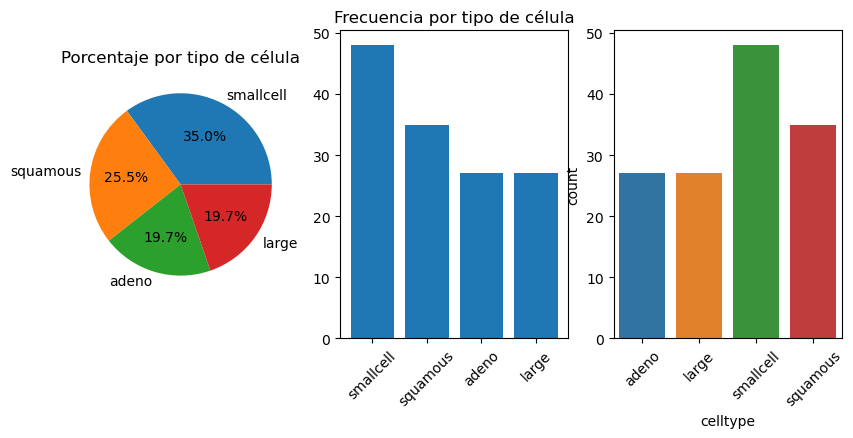

In [18]:
fig,ax = plt.subplots(1,3,figsize=(10,4))

ax[0].pie(prop_cel, labels=prop_cel.index, autopct='%.1f%%')
ax[0].title.set_text('Porcentaje por tipo de célula')
ax[1].bar(freq.index,height=freq.values) 
ax[1].title.set_text('Frecuencia por tipo de célula')
sns.countplot(data=df, x ="celltype",ax=ax[2]) # Esto es para poner axis labels, pero puede quitar formato
# Para no quitar formato usa:
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Tipo de inseguridad alimentaria')
# Rotaciones de labels
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
# displaying chart
plt.show()

([<matplotlib.patches.Wedge at 0x211e156e500>,
 [Text(0.49826549499298955, 0.9806790996546176, 'smallcell'),
  Text(-1.0896046511478596, 0.15086982533612026, 'squamous'),
  Text(-0.3110058391003899, -1.0551186511693662, 'adeno'),
  Text(0.8958117872564462, -0.638373904394918, 'large')],
 [Text(0.33972647385885646, 0.6686448406736029, '35.0%'),
  Text(-0.7429122621462678, 0.10286579000190016, '25.5%'),
  Text(-0.21204943575026586, -0.7193990803427496, '19.7%'),
  Text(0.6107807640384859, -0.4352549348147168, '19.7%')])

Text(0.5, 1.0, 'Porcentaje de tipos de células cancerígenas en la muestra')

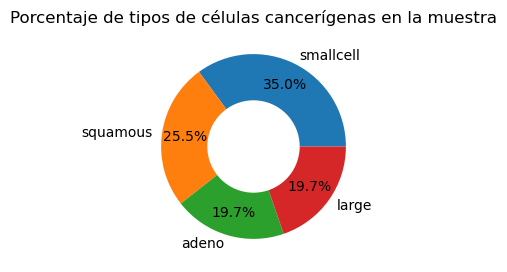

In [19]:
fig,ax = plt.subplots(figsize=(5,3))
plt.pie(prop_cel, labels=prop_cel.index,
        autopct='%1.1f%%', pctdistance=0.75,
        )
# Dibuja círculo
centre_circle = plt.Circle((0, 0), 0.5, fc='white')
fig = plt.gcf()
  
# Adiciona círculo al pie
fig.gca().add_artist(centre_circle)
  
plt.title('Porcentaje de tipos de células cancerígenas en la muestra')

In [ ]:
## Otro ejemplo mío :D ##
# Chécate https://proclusacademy.com/blog/customize_matplotlib_piechart/
#
#
# Información
prop_ali_lim = df['ali_lim'].value_counts(normalize=True)
prop_ali_lim

freq = df['ali_lim'].value_counts()

labels = ['Decente','Limitada']

# Gráfica de pie

textprops={'color':'black', 'fontsize':12.5} # Font de toda la gráfica
explode = (0.05,0.05)   # Pedazos del pie separados

fig,ax = plt.subplots(figsize=(6,6))
_, _, autopcts = plt.pie(prop_ali_lim, # El _ es figura anónima y el autopcts es sólo si quieres font diferente en labels
                        autopct='%1.1f%%', # Estos son los decimales de los porcentajes
                        pctdistance=0.75,   # PCT distance es distancia de porcentajes
                        labels=labels, labeldistance=1.05,     
                        textprops=textprops,                   #Font general
                        explode=explode                       
                        #wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' },   # Esto es borde, sirve para dona porque no hay desfase, en lugar de explode
                        )

# Círculo intero
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  

# Texto
sns.set(font_scale = 1.2) # Escala de todos los textos
fig.set_facecolor('white')      # Fondo
# plt.setp(autopcts, **{'weight':'bold', 'fontsize':12.5})
plt.title('Porcentaje de tipos de células cancerígenas en la muestra')

plt.show(); # Con ; para eliminar el texto antes de la gráfica

#### Hallazgos
+ No hay desbalance severo entre las muestras de cada tipo de célula
+ La mayoría de los veteranos tiene cáncer de pulmón de célula pequeña
+ La gráfica de conteo de seaborn maneja colores diferentes y calcula automáticamente las frecuencias para cada categoría

#### trt

([<matplotlib.patches.Wedge at 0x211e1603820>,
 [Text(-0.012612015577909001, 1.0999276962887437, '1'),
  Text(0.012612118560571721, -1.0999276951079169, '2')],
 [Text(-0.006879281224314, 0.5999605616120419, '50.4%'),
  Text(0.006879337396675483, -0.5999605609679546, '49.6%')])

<Axes: title={'center': 'Frecuencia con tratamiento 1 y 2'}, xlabel='trt', ylabel='count'>

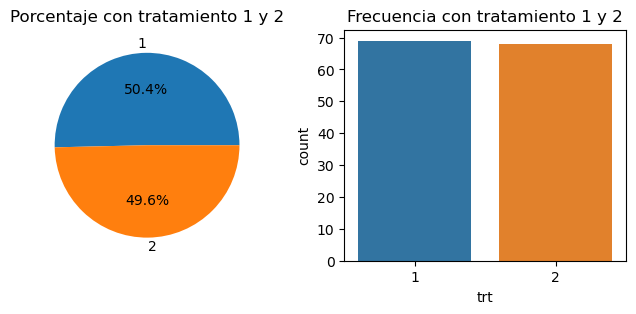

In [20]:
prop_trt = df.trt.value_counts(normalize=True)
frec = df.trt.value_counts()
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].title.set_text('Porcentaje con tratamiento 1 y 2')  
ax[1].title.set_text('Frecuencia con tratamiento 1 y 2')
ax[0].pie(prop_trt, labels=prop_trt.index, autopct='%.1f%%')

sns.countplot(data=df, x ="trt",ax=ax[1])
plt.show()

#### Hallazgo
+ Casi igual la cantidad de pacientes en cada tipo de tratamiento

#### prior

([<matplotlib.patches.Wedge at 0x211e11580a0>,
 [Text(-0.6688034735918211, 0.8733280676306667, '0'),
  Text(0.6688034735918207, -0.8733280676306672, '10')],
 [Text(-0.36480189468644786, 0.4763607641621818, '70.8%'),
  Text(0.3648018946864476, -0.476360764162182, '29.2%')])

<Axes: title={'center': 'Frecuencia con tratamiento previo'}, xlabel='prior', ylabel='count'>

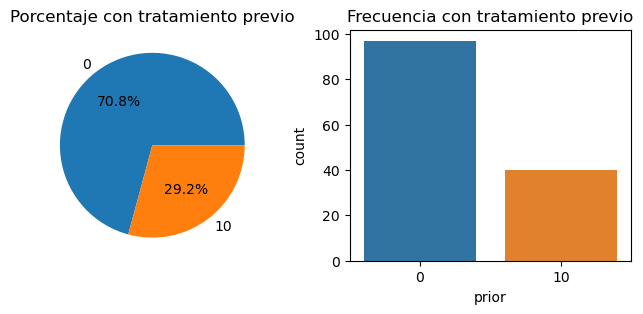

In [21]:
prop_pr = df.prior.value_counts(normalize=True)

fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].title.set_text('Porcentaje con tratamiento previo')  
ax[1].title.set_text('Frecuencia con tratamiento previo')  
ax[0].pie(prop_pr, labels=prop_pr.index, autopct='%.1f%%')
sns.countplot(data=df, x ="prior",ax=ax[1])
plt.show()

#### Hallazgo
+ La mayoría de los pacientes(70.8 %) no tuvo tratamiento previo

#### status

([<matplotlib.patches.Wedge at 0x211e13db9d0>,
 [Text(-1.076656586767007, 0.22541205418348575, '1'),
  Text(1.0766565814908566, -0.22541207938445176, '0')],
 [Text(-0.5872672291456401, 0.12295202955462858, '93.4%'),
  Text(0.58726722626774, -0.12295204330061003, '6.6%')])

<Axes: title={'center': 'Frecuencia por status'}, xlabel='status', ylabel='count'>

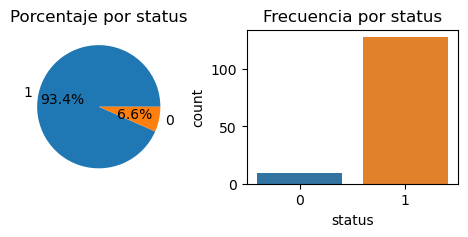

In [22]:
prop_st = df.status.value_counts(normalize=True)

fig,ax = plt.subplots(1,2,figsize=(6,2))
ax[0].title.set_text('Porcentaje por status')  
ax[1].title.set_text('Frecuencia por status')  
ax[0].pie(prop_st, labels=prop_st.index, autopct='%.1f%%')
sns.countplot(data=df, x ="status",ax=ax[1])
plt.show()

#### Hallazgo
+ Casi no hubo pacientes censurados (6.6%). Estos son aquellos de los que se desconoce si fallecieron o no, pues se les perdió el rastro durante el ensayo clínico.

### Histograma (recomendado para variables de intervalo y razón)

+ Un histograma es una herramienta de visualización clásica que representa la distribución de una o más variables al contar el número de observaciones que se encuentran dentro de contenedores discretos (bins).

+ La función histplot() de seaborn puede normalizar la estadística calculada dentro de cada contenedor para estimar la frecuencia, la densidad o la masa de probabilidad, y puede agregar una curva suave obtenida mediante una estimación de la densidad del kernel, similar a kdeplot().

+ seaborn.histplot() calcula la cantidad de contenedores (bin)s. La elección de los contenedores para calcular y trazar un histograma puede ejercer una influencia sustancial en los conocimientos que uno puede extraer de la visualización. Si los contenedores son demasiado grandes, pueden borrar funciones importantes. Por otro lado, los contenedores que son demasiado pequeños pueden estar dominados por la variabilidad aleatoria, lo que oscurece la forma de la verdadera distribución subyacente. El tamaño del contenedor predeterminado se determina mediante una regla de referencia que depende del tamaño y la varianza de la muestra. Esto funciona bien en muchos casos (es decir, con datos de "buen comportamiento") pero falla en otros. Siempre es bueno probar diferentes tamaños de contenedores para asegurarse de que no se está perdiendo algo importante. Esta función le permite especificar contenedores de varias maneras diferentes, como establecer el número total de contenedores que se usarán, el ancho de cada contenedor o las ubicaciones específicas donde los contenedores deben dividirse.

http://citadel.sjfc.edu/faculty/kgreen/DataAM_Web/TextBook/MSTI130_TextFall2011_Chapter%2005.pdf

### Se puede, pero no se debe usar un histograma para categóricas

<Axes: >

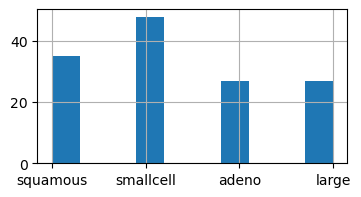

In [23]:
fig,ax = plt.subplots(figsize=(4,2))
# hist() es método de pandas
# En el eje y se muestra frecuencia
df.celltype.hist()  # 10 bins por defecto 
# En este caso se recomienda el diagrama de barras

### Conclusión

+ El histograma debe usarse para variables de intervalo o razón y NO para una nominal, como es este caso.
+ Lo correcto es usar el diagrama de barras, como se muestra a continuación
+ Este diagrama muestra de mayor a menor las frecuencias de ocurrencia

## Conversión a dummy

Se convertirán las categóricas a variables dicotómicas. Esto permitirá manejarlas como numéricas con valores de cero o uno. Es parte de una actividad de ingeniería de características.

In [24]:
#pd.get_dummies?

In [25]:
df_dum_todas = pd.get_dummies(df) # si la variable tiene k categorías, crea k nuevas columnas
df_dum_todas

,time,karno,diagtime,age,trt_1,trt_2,celltype_adeno,celltype_large,celltype_smallcell,celltype_squamous,status_0,status_1,prior_0,prior_10
0,72,60,7,69,1,0,0,0,0,1,0,1,1,0
1,411,70,5,64,1,0,0,0,0,1,0,1,0,1
2,228,60,3,38,1,0,0,0,0,1,0,1,1,0
3,126,60,9,63,1,0,0,0,0,1,0,1,0,1
4,118,70,11,65,1,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,133,75,1,65,0,1,0,1,0,0,0,1,1,0
133,111,60,5,64,0,1,0,1,0,0,0,1,1,0
134,231,70,18,67,0,1,0,1,0,0,0,1,0,1
135,378,80,4,65,0,1,0,1,0,0,0,1,1,0


In [26]:
df_dum_todas.celltype_adeno.sum(),
df_dum_todas.celltype_large.sum(),
df_dum_todas.celltype_smallcell.sum(),
df_dum_todas.celltype_squamous.sum()

(27,)

(27,)

(48,)

35

In [27]:
df_dum = pd.get_dummies(df,drop_first=True) # toma solo las categóricas y usa k-1 columnas
df_dum

,time,karno,diagtime,age,trt_2,celltype_large,celltype_smallcell,celltype_squamous,status_1,prior_10
0,72,60,7,69,0,0,0,1,1,0
1,411,70,5,64,0,0,0,1,1,1
2,228,60,3,38,0,0,0,1,1,0
3,126,60,9,63,0,0,0,1,1,1
4,118,70,11,65,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
132,133,75,1,65,1,1,0,0,1,0
133,111,60,5,64,1,1,0,0,1,0
134,231,70,18,67,1,1,0,0,1,1
135,378,80,4,65,1,1,0,0,1,0


In [28]:
df_dum.celltype_large.sum(),df_dum.celltype_smallcell.sum(),df_dum.celltype_squamous.sum()

(27, 48, 35)

In [29]:
df_dum = pd.concat([df[['trt','prior','celltype']], df_dum], axis=1) #le añade las columnas originales
df_dum

,trt,prior,celltype,time,karno,diagtime,age,trt_2,celltype_large,celltype_smallcell,celltype_squamous,status_1,prior_10
0,1,0,squamous,72,60,7,69,0,0,0,1,1,0
1,1,10,squamous,411,70,5,64,0,0,0,1,1,1
2,1,0,squamous,228,60,3,38,0,0,0,1,1,0
3,1,10,squamous,126,60,9,63,0,0,0,1,1,1
4,1,10,squamous,118,70,11,65,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2,0,large,133,75,1,65,1,1,0,0,1,0
133,2,0,large,111,60,5,64,1,1,0,0,1,0
134,2,10,large,231,70,18,67,1,1,0,0,1,1
135,2,0,large,378,80,4,65,1,1,0,0,1,0


### Análisis univariado para intervalo y razón

+ Vamos a visualizar estas variables con histogramas, diagramas de densidad, diagramas de cajas y bigotes, diagramas de barra de la biblioteca seaborn, entre otros

#### Diagrama de densidad

Un gráfico de densidad visualiza la distribución de datos en un intervalo o período de tiempo continuo. Este gráfico es una variación de un histograma que utiliza el suavizado del kernel para trazar valores, lo que permite distribuciones más suaves al suavizar el ruido.

#### karno

<Axes: xlabel='karno', ylabel='Count'>

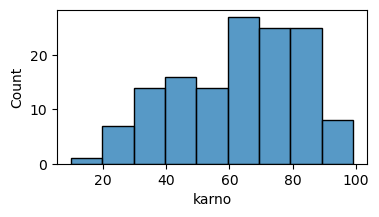

In [30]:
fig,ax = plt.subplots(figsize=(4,2))
sns.histplot(data=df_dum,x='karno')
# seaborn determina que 9 bins es lo mejor

<Axes: xlabel='karno', ylabel='Count'>

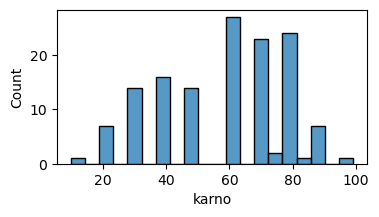

In [31]:
# Note que al cambiar a 20 bins se resaltan rangos de valores en los que no hay muestras
fig,ax = plt.subplots(figsize=(4,2))
sns.histplot(data=df_dum,x='karno', bins=20)

<Axes: xlabel='karno', ylabel='Count'>

<Axes: xlabel='karno'>

<Axes: ylabel='karno'>

<Axes: xlabel='karno'>

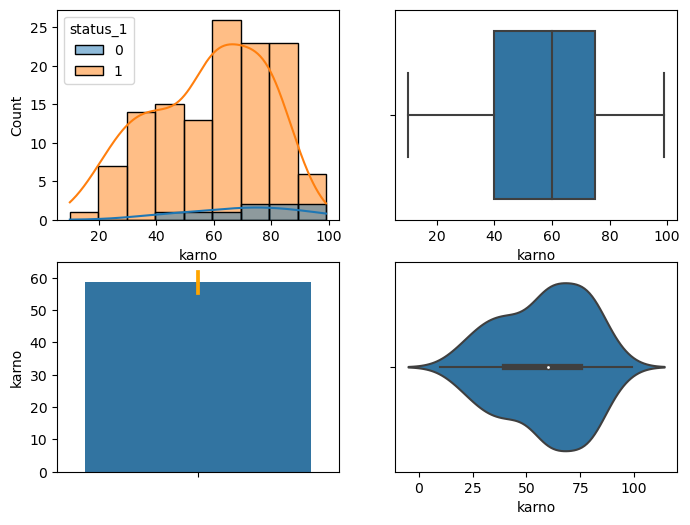

In [32]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
sns.histplot(data=df_dum,x='karno',hue='status_1',kde=True,ax=ax[0,0]) #visualiza densidad de kernel
sns.boxplot(x=df_dum.karno,ax=ax[0,1])
sns.barplot(data=df_dum, y="karno",errcolor='orange',ax=ax[1,0])
sns.violinplot(x=df_dum["karno"],ax=ax[1,1]) # por defecto dibuja un boxplot en miniatura

<Figure size 400x300 with 0 Axes>

<Axes: xlabel='karno', ylabel='count'>

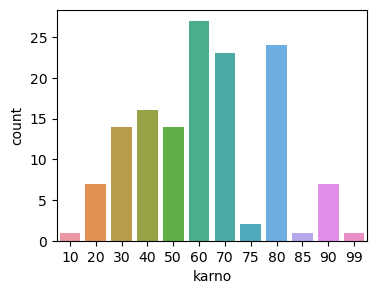

In [33]:
plt.figure(figsize=(4,3))
sns.countplot(data=df_dum, x ="karno")
# Aquí el intervalo de confianza es del 95% (ci), calculado con 1000 bootstraps

In [34]:
df_dum.columns

Index(['trt', 'prior', 'celltype', 'time', 'karno', 'diagtime', 'age', 'trt_2',
       'celltype_large', 'celltype_smallcell', 'celltype_squamous', 'status_1',
       'prior_10'],
      dtype='object')

### Ejemplo de gráfica interactiva

In [35]:
@interact
def grafica(col=df_dum[['trt', 'prior', 'celltype', 'status_1','karno']]):
    sns.countplot(data=df_dum[['trt', 'prior', 'celltype', 'status_1','karno']], x = col )

interactive(children=(Dropdown(description='col', options=('trt', 'prior', 'celltype', 'status_1', 'karno'), v…

#### Interpretación

+ No hay outliers
+ La media está ligeramente más abajo que la mediana

#### diagtime

<Axes: xlabel='diagtime', ylabel='Count'>

<Axes: xlabel='diagtime'>

<Axes: ylabel='diagtime'>

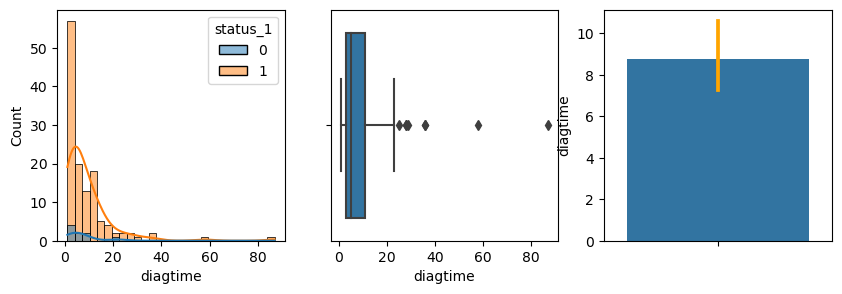

In [36]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
sns.histplot(data=df_dum, x="diagtime", hue='status_1',kde=True,ax=ax[0])  #visualiza densidad de kernel
sns.boxplot(x=df_dum.diagtime,ax=ax[1])
sns.barplot(data=df_dum, y="diagtime",errcolor='orange',ax=ax[2])

#### Interpretación

+ Hay outliers
+ El diagnóstico se hizo fundamentalmente antes de los 25 días

#### age

<Axes: xlabel='age', ylabel='Count'>

<Axes: xlabel='age'>

<Axes: ylabel='age'>

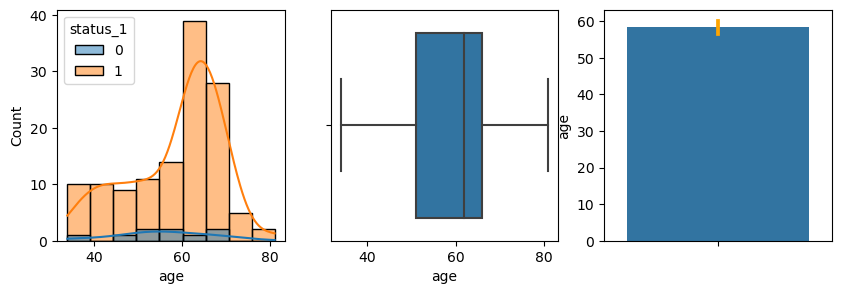

In [37]:
fig,ax = plt.subplots(1,3,figsize=(10,3))
sns.histplot(data=df_dum, x="age", hue='status_1',kde=True,ax=ax[0])  #visualiza densidad de kernel
sns.boxplot(x=df_dum.age,ax=ax[1])
sns.barplot(data=df_dum, y="age",errcolor='orange',ax=ax[2])

#### Interpretación

+ No hay outliers
+ La mayor densidad de pacientes está entre 60 y 70 años
+ La media es menor que la mediana

#### time

<Axes: xlabel='time', ylabel='Count'>

<Axes: xlabel='time'>

<Axes: ylabel='time'>

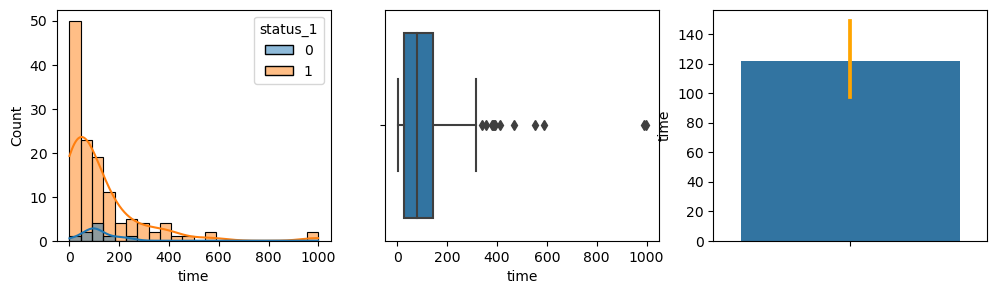

In [38]:
fig,ax = plt.subplots(1,3,figsize=(12,3))
sns.histplot(data=df_dum, x="time", hue='status_1',kde=True,ax=ax[0])
sns.boxplot(x=df_dum.time,ax=ax[1])#visualiza densidad de kernel
sns.barplot(data=df_dum, y="time",errcolor='orange',ax=ax[2])

#### Interpretación

+ No hay casi datos entre el día 600 y el 1000. 
+ Los últimos datos son atípicos (outliers)
+ La mayoría de los veteranos muere antes del día 200
+ Muy pocos veteranos se salieron del estudio (status=0)
+ El tiempo mínimo es de 0 días y tenemos una media de 120 con desviación estándard de 157 !!!!

### Uso de escala logarítmica

Las escalas logarítmicas resultan útiles cuando los datos que visualiza son muchos menos o muchos más que el resto de los datos o cuando las diferencias entre los valores son importantes. También puede usarla si los valores del gráfico cubren un rango muy amplio.

<Axes: xlabel='time', ylabel='Count'>

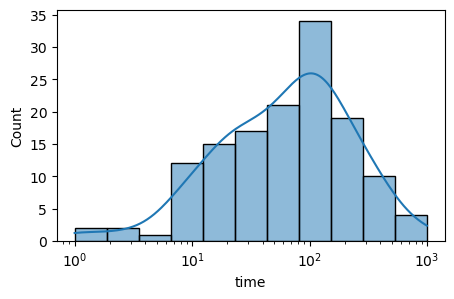

In [39]:
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(data=df_dum, x="time", kde=True,log_scale=True) # por defecto es logaritmo en base 10

### Interpretación

+ Pocos pacientes murieron antes de los 10 días desde el inicio del estudio.
+ La mayor cantidad murió alrededor de los 100 días
+ Puede crearse una nueva característica con el logaritmo del tiempo y tendría una distribución más cercana a la normal.

In [40]:
df_dum['log_time'] = np.log10(df_dum['time'])  # Nueva característica
df_dum['log_time']

0      1.857332
1      2.613842
2      2.357935
3      2.100371
4      2.071882
         ...   
132    2.123852
133    2.045323
134    2.363612
135    2.577492
136    1.690196
Name: log_time, Length: 137, dtype: float64

### Otras opciones para los diagramas de violín

<Axes: xlabel='karno'>

<Axes: xlabel='karno'>

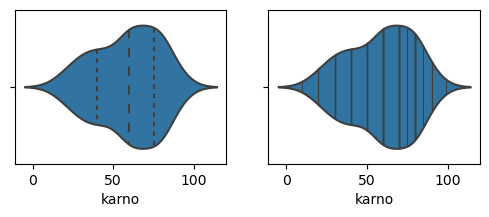

In [41]:
fig,ax = plt.subplots(1,2,figsize=(6,2))
sns.violinplot(x=df_dum["karno"],inner='quartile',ax=ax[0])
sns.violinplot(x=df_dum["karno"],inner='stick',ax=ax[1])

### Interpretación

+ La puntuación de karno tiene una densidad mayor entre 60 y 80, con un pico cercano a 70 y con mediana en 60

## Ejercicio para resaltar la diferencia de sintaxis en matplotlib y seaborn para enviar un plot a un eje

(array([35.,  0.,  0., 48.,  0.,  0., 27.,  0.,  0., 27.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 0.98, 'Histogramas')

([0, 1, 2, 3],
 [Text(0, 0, 'adeno'),
  Text(1, 0, 'large'),
  Text(2, 0, 'smallcell'),
  Text(3, 0, 'squamous')])

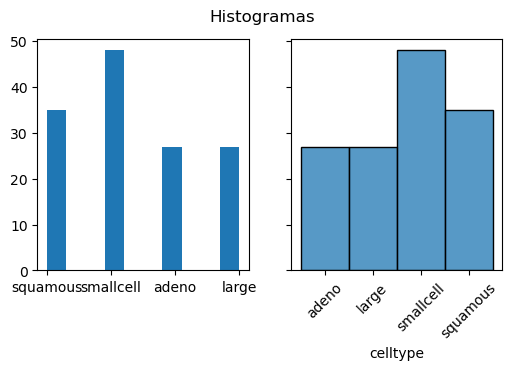

In [42]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(6,3),sharey=True)
#eje.plot
axs[0].hist(df.celltype)

#eje = plot
axs[1] = sns.histplot(data=df_dum,x=df_dum.celltype)

plt.suptitle('Histogramas')
plt.xticks(rotation=45)
plt.show()

### Interpretación

+ Notar que la cantidad de bins por defecto con seaborn y matplotlib es diferente. 
Los histogramas no son adecuados para este cao. Note que no cambia de colores como en el countplot()


### Diagramas categóricos

+ Es un diagrama de la biblioteca seaborn que opera a nivel de FaceGrid, por lo que el ancho y la altura del gráfico hay que especificarlo con los parámetros height y scale. el objeto FaceGrid devuelto es el que se puede usar para hacer subplots.
+ Sin especificar una categoría por el eje de las y, permite visualizar densidad de puntos para cada valor de la x
+ Son mejores para análisis multivariado, especialmente el bivariado

In [43]:
#sns.catplot?

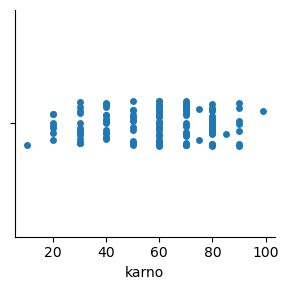

In [44]:
sns.catplot(data=df_dum, x="karno",height=3)

### Guardar archivo con nuevas columnas dummies y guardar tipos de cada columna en archivo

Estos archivos se usará en otros notebooks para análisis multivariado

+ El formato npy es el formato de archivo binario estándar en NumPy para conservar un arreglo NumPy cualquiera en el disco. El formato almacena toda la información de forma y tipo necesaria para reconstruir el arreglo correctamente incluso en otra máquina con una arquitectura diferente.
+ Un archivo pkl es un archivo creado por pickle, un módulo de Python que permite que los objetos se serialicen en archivos en el disco y se deserialicen nuevamente en el programa en tiempo de ejecución. Contiene un flujo de bytes que representa los objetos. El archivo contiene secuencias de bytes que representan su contenido.

In [48]:
# Guardar tipos de cada columna
tipos = pd.DataFrame(df_dum.dtypes,columns=['dtypes'])

non_date = tipos[tipos['dtypes'] != 'datetime64[ns]']

non_date.to_csv('tipos_veteranos.csv',index_label='columnas',header=['tipos'],encoding='utf_8')

In [49]:
'''import pickle

# Guardar lista de columnas datatime, si hubiere
lista_fechas = list(df_dum.dtypes[df_dum.dtypes == '<M8[ns]'].index)

np.save( "lista_fechas.npy", lista_fechas, allow_pickle=True)  # forma 1

# Forma 2
with open('lista_fechas.pkl','wb') as f:
    np.dump(lista_fechas)'''

'import pickle\n\n# Guardar lista de columnas datatime, si hubiere\nlista_fechas = list(df_dum.dtypes[df_dum.dtypes == \'<M8[ns]\'].index)\n\nnp.save( "lista_fechas.npy", lista_fechas, allow_pickle=True)  # forma 1\n\n# Forma 2\nwith open(\'lista_fechas.pkl\',\'wb\') as f:\n    np.dump(lista_fechas)'

In [50]:
df_dum.to_csv('dataset-25346_dum.csv',index=False,encoding='utf-8')